In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import fredapi as fa
from scipy import stats
import numpy as np
sns.set()

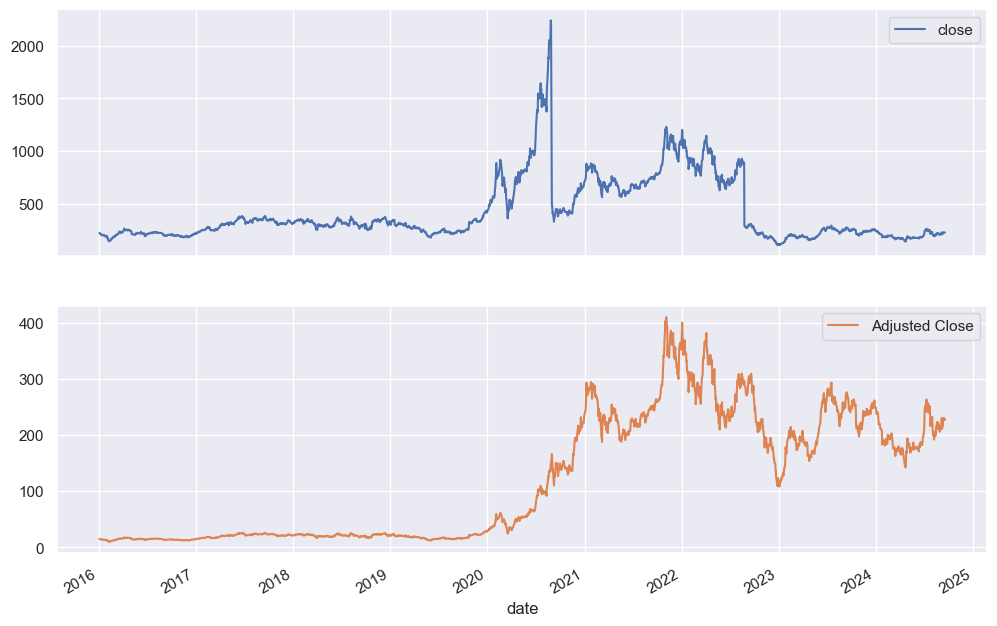

In [3]:
#你不能拿一只在 2020 拆过 5 次的股票跟没拆过的股票混在一起算收益，那等于你说“我家的冰箱是5个小冰箱拼起来的，所以家里变凉了。”不，你只是在骗人。


# 引入数据：从 GitHub 上读取 TSLA 历史价格
tsla = pd.read_csv("https://raw.githubusercontent.com/DonLeKouT/Just_files/refs/heads/main/TSLA_stock_price.csv")

# 设置日期为索引列（方便按时间过滤和处理）
tsla.set_index('date', inplace=True)

# 把字符串时间变成 pandas 能识别的时间格式
tsla.index = pd.to_datetime(tsla.index)

# 拆股信息：两个拆股事件
# 2020-08-31 拆5：1；2022-08-25 拆3：1
splits = {
    '2022-08-25' : 3,   # 每1股变成3股（价格 / 3）
    "2020-08-31" : 5    # 每1股变成5股（价格 / 5）
}

# 复制一份 close 列作为 Adjusted Close 初始值
tsla['Adjusted Close'] = tsla['close'].copy()

# ！   遍历每个拆股事件，调整拆股之前的价格（注意是"之前"）
for date, split in splits.items():
    # 拆股是在这天执行的，我们要往前一天调整价格
    date = pd.to_datetime(date) - pd.Timedelta(days=1)

    # ！ 所有早于该时间的价格都需要被“除以”拆股因子（例如 1变3 股价降为1/3）
    tsla.loc[:date, 'Adjusted Close'] = tsla.loc[:date, 'Adjusted Close'] / split

# 画图：展示 2016 年起的 close 和 adjusted close 走势
tsla[['close', 'Adjusted Close']].loc["2016":].plot(figsize=(12, 8), subplots = True)

# 显示图像
plt.show()


/Users/huayitang/PycharmProjects/WQU_Msc_notes/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


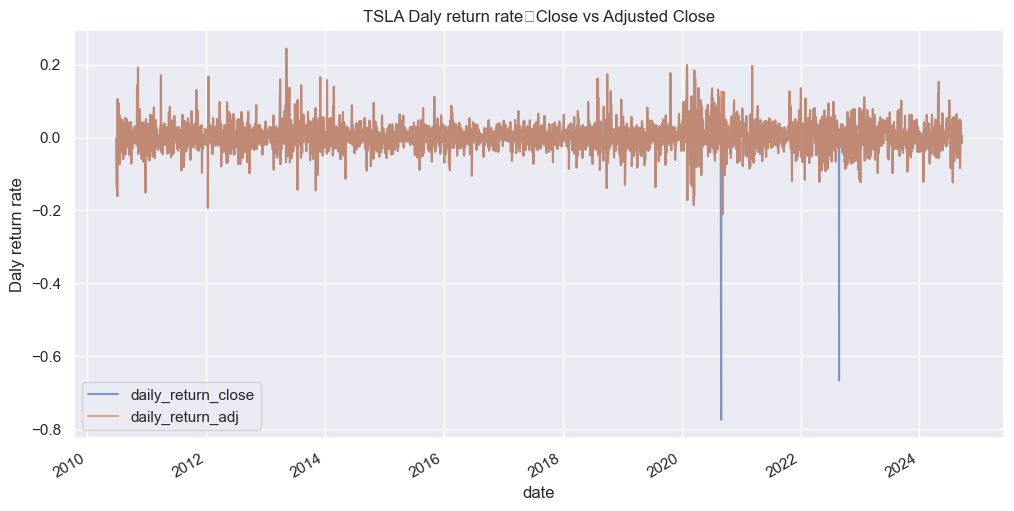

Daly return rate mean ： 0.00043737117886012196
Daly return max： 0.9005511882172224


In [5]:
'''
🧪 Exercise 2：计算 TSLA 每日收益率（close 和 adjusted-close）
✅ 目标：
比较用 原始收盘价 和 调整后收盘价 计算出来的日收益率，有没有区别。

Spoiler alert：如果只有拆股，没有分红，收益率几乎一模一样。你等等就看到了。

'''

# 计算日收益率（百分比形式）
tsla['daily_return_close'] = tsla['close'].pct_change()
tsla['daily_return_adj'] = tsla['Adjusted Close'].pct_change()

# 可视化收益率对比
tsla[['daily_return_close', 'daily_return_adj']].dropna().plot(figsize=(12,6), alpha=0.7)
plt.title("TSLA Daly return rate：Close vs Adjusted Close")
plt.ylabel("Daly return rate")
plt.xlabel("date")
plt.grid(True)
plt.show()

# 对比两者差值有多大
diff = (tsla['daily_return_close'] - tsla['daily_return_adj']).abs()
print("Daly return rate mean ：", diff.mean())
print("Daly return max：", diff.max())


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


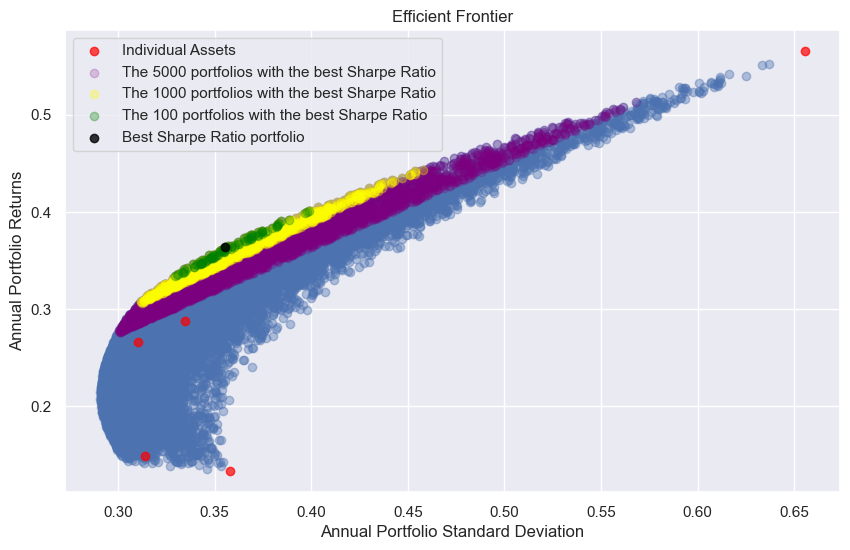

In [7]:
'''
3. Portfolio Sharpe Ratio and the Efficient Frontier
3. 投资组合夏普比率与有效前沿

我们在上一单元中已经提到了夏普比率的含义。现在我们将阐述夏普比率在投资组合管理中的重要性。为此，我们将假设第一课中的资产，




##########并展示夏普比率最高的投资组合相对于有效前沿的位置。

# 随机生成2万组投资组合权重（5只股票）
weights = np.random.dirichlet(np.ones(5)*0.7, 20000)

# 计算每个组合的三要素：
for w in weights:
  收益 = 股票平均收益 @ 权重       # 收益 = Σ(股票收益×权重)
  风险 = √(权重ᵀ × 协方差矩阵 × 权重) # 风险 = 组合波动率
  夏普 = (收益 - 无风险利率) / 风险
'''
assets = ['MSFT', 'AAPL', 'AMZN', 'TSLA', 'GOOGL']  # 定义投资组合中的资产（微软、苹果、亚马逊、特斯拉、谷歌）

# 下载这些资产的“调整后收盘价”数据（自动调整分红/拆股），从2018年到2023年
asset_prices = yf.download(assets, start='2018-01-01', end='2023-01-01', auto_adjust = False)['Adj Close']

# 把索引转换为纯日期，避免时间信息造成的混乱
asset_prices.index = pd.to_datetime(asset_prices.index.date)

# 下载无风险利率的数据（3个月期美债，符号是 ^IRX）
risk_free = yf.download('^IRX', start='2018-01-01', end='2023-01-01', auto_adjust = False)['Adj Close']
risk_free.index = pd.to_datetime(risk_free.index.date)

# 计算每日收益率（百分比收益率），用的是 pct_change，之后删除第一行的缺失值
r = asset_prices.pct_change().dropna()

# 使用 Dirichlet 分布生成 20000 组投资组合权重（5个资产），每组权重之和为 1
weights = np.random.dirichlet(np.ones(5)*0.7, size = 20000)

# 检查所有权重组合是否都满足“权重和为 1”的条件
assert np.isclose(np.sum(weights, axis = 1), 1).all()

# 存放每组权重对应的收益、波动率、夏普比
eff_front_dict = {}

# 年化协方差矩阵（因为我们用的是日收益率）
cov_matrix_ret = r.cov() * 252

# 每只资产的年化预期收益
expected_returns = r.mean() * 252

# 获取无风险利率（已经是年化的），转换为小数
risk_free_rate = risk_free['^IRX'].mean() / 100

# 遍历每组权重，计算对应的组合表现
for w in weights:
    port_ret = expected_returns @ w.T  # 投资组合的预期年化收益
    port_std = np.sqrt(w.T @ cov_matrix_ret @ w)  # 投资组合的年化波动率
    sharpe_ratio = (port_ret - risk_free_rate) / port_std  # 计算夏普比
    eff_front_dict[str(list(w))] = [port_ret, port_std, sharpe_ratio]  # 保存结果

# 整理成 DataFrame，行是不同组合，列是收益、风险、夏普比
eff_frontier_dataframe = pd.DataFrame(
    eff_front_dict,
    index = ['Returns', 'Standard Deviation', 'Sharpe Ratio']
).T

# 按照夏普比从高到低排序，找出最优组合
highest_sharpe_ratio = eff_frontier_dataframe.sort_values(by = 'Sharpe Ratio', ascending = False)

# 画图开始！—— 散点图展示所有组合的收益 vs 风险
plt.figure(figsize = (10,6))
plt.scatter(
    x = eff_frontier_dataframe['Standard Deviation'],
    y = eff_frontier_dataframe['Returns'],
    alpha = 0.4
)

# 用红点标出单个资产的位置（不是组合）
plt.scatter(
    x = r.std() * np.sqrt(252),
    y = expected_returns,
    color = 'red',
    label = "Individual Assets",
    alpha = 0.7
)

# 分层标记最优秀的组合们
plt.scatter(
    x = highest_sharpe_ratio[:5000]['Standard Deviation'],
    y = highest_sharpe_ratio[:5000]['Returns'],
    color = 'purple',
    alpha = 0.2,
    label = "The 5000 portfolios with the best Sharpe Ratio"
)
plt.scatter(
    x = highest_sharpe_ratio[:1000]['Standard Deviation'],
    y = highest_sharpe_ratio[:1000]['Returns'],
    color = 'yellow',
    alpha = 0.3,
    label = "The 1000 portfolios with the best Sharpe Ratio"
)
plt.scatter(
    x = highest_sharpe_ratio[:100]['Standard Deviation'],
    y = highest_sharpe_ratio[:100]['Returns'],
    color = 'green',
    alpha = 0.3,
    label = "The 100 portfolios with the best Sharpe Ratio"
)

# 标记出最优组合（夏普比最高那个）
plt.scatter(
    x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'],
    y = highest_sharpe_ratio.iloc[0,:]['Returns'],
    color = 'black',
    alpha = 0.8,
    label = "Best Sharpe Ratio portfolio"
)

# 图表格式设置
plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()



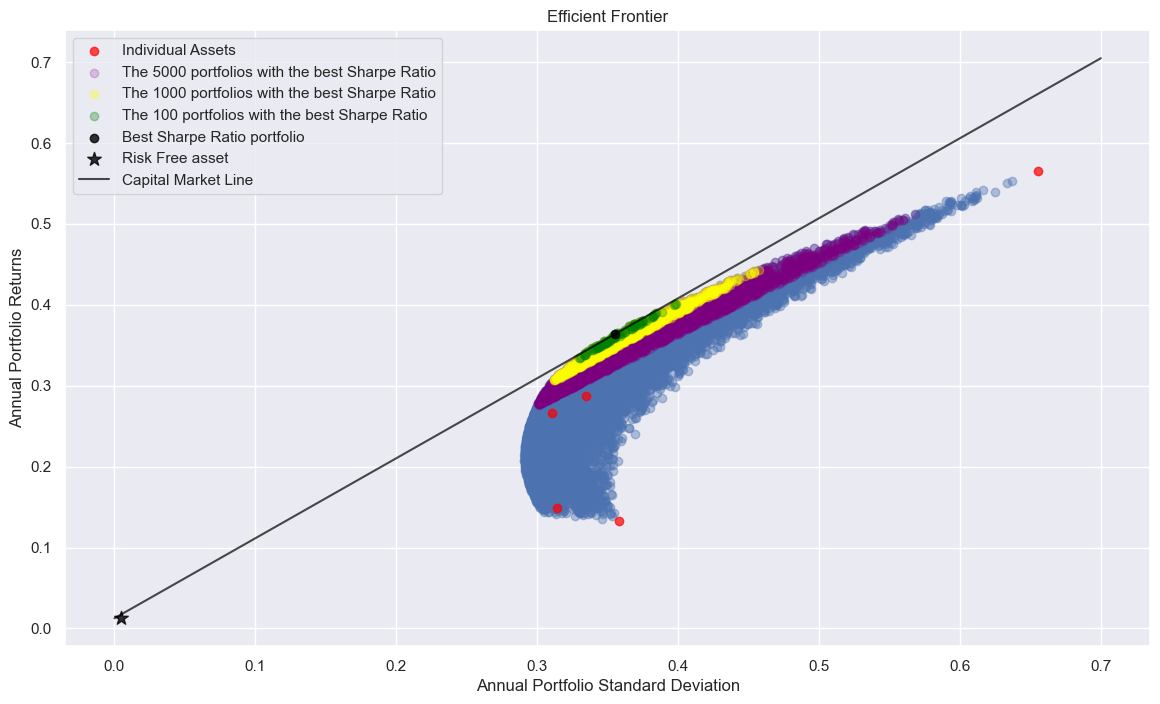

In [8]:
'''本段代码的目的是绘制“资本市场线（Capital Market Line，CML）”。
CML 是投资组合理论中最重要的一条线，它展示了：
1. 投资人可以通过把资金分配到“无风险资产 + 最优风险组合”之间，构建出更好的投资组合。
2. 它的斜率 = Sharpe Ratio 最优的投资组合（也叫切线组合）。
3. CML 上的每一点都是某种“你买了部分无风险资产 + 某个比例的最优风险资产”的组合。

知识点涵盖：
- 夏普比率（Sharpe Ratio）衡量风险调整后收益的能力。
- 投资组合收益和波动（均值 + 协方差矩阵）。
- 无风险资产的引入如何改变投资边界。
- CML 是有效前沿线中最优的那条直线。

图中展示：
- 所有可能组合的点（蓝色）
- 单个资产的风险和收益（红色）
- 各种 Sharpe 比较高的组合（紫、黄、绿点）
- 无风险资产（黑色星号）
- CML（黑线），起于无风险资产，切于最优 Sharpe 投组合点

一句话总结：
**这段代码帮你看懂了“合理投资”的上限长什么样，CML 是你配置资产的神之参考线。**
'''

sigmas = np.linspace(0,0.7, 100)
CML = risk_free_rate + highest_sharpe_ratio['Sharpe Ratio'].iloc[0] * sigmas # This is the Capital Market Line

# Plot the portfolio returns vs portfolio variance
plt.figure(figsize = (14,8))
plt.scatter(x = eff_frontier_dataframe['Standard Deviation'], y = eff_frontier_dataframe['Returns'], alpha = 0.4)
plt.scatter(x = r.std() * np.sqrt(252), y = expected_returns, color = 'red', label = "Individual Assets", alpha = 0.7)
plt.scatter(x = highest_sharpe_ratio[:5000]['Standard Deviation'], y = highest_sharpe_ratio[:5000]['Returns'], color = 'purple', alpha = 0.2, label = "The 5000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:1000]['Standard Deviation'], y = highest_sharpe_ratio[:1000]['Returns'], color = 'yellow', alpha = 0.3, label = "The 1000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:100]['Standard Deviation'], y = highest_sharpe_ratio[:100]['Returns'], color = 'green', alpha = 0.3, label = "The 100 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'], y = highest_sharpe_ratio.iloc[0,:]['Returns'], color = 'black', alpha = 0.8, label = "Best Sharpe Ratio portfolio" )
plt.scatter(x = (risk_free / 252).std(), y = risk_free_rate, color = 'black', alpha = 0.8, marker = '*', label = "Risk Free asset", s = 105)
plt.plot(sigmas, CML, color = 'black', label = "Capital Market Line", alpha = 0.7)


plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()